In [1]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
from misc import get_attr
import time
pd.set_option('mode.chained_assignment', None)
from framework import tester, strategy
from environments.gym_env import TradingEnv



In [2]:
spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


           date        open        high         low       close    adjclose  \
7006 2020-11-23  357.279999  358.820007  354.869995  357.459991  345.652832   
7007 2020-11-24  360.209991  363.809998  359.290009  363.220001  351.222626   
7008 2020-11-25  363.130005  363.160004  361.480011  362.660004  350.681091   
7009 2020-11-27  363.839996  364.179993  362.579987  363.670013  351.657776   
7010 2020-11-30  362.829987  363.119995  359.170013  362.059998  350.100922   
...         ...         ...         ...         ...         ...         ...   
7581 2023-03-09  399.739990  401.480011  390.529999  391.559998  391.559998   
7582 2023-03-10  390.989990  393.160004  384.320007  385.910004  385.910004   
7583 2023-03-13  381.809998  390.390015  380.649994  385.359985  385.359985   
7584 2023-03-14  390.500000  393.450012  387.049988  391.730011  391.730011   
7585 2023-03-15  385.890015  389.489990  383.709991  389.279999  389.279999   

         volume ticker    signal  signal+1  
7006  

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


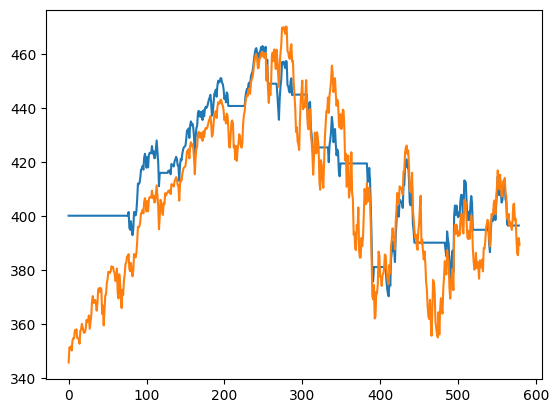

In [3]:
class ma_crossover_policy:
    def __init__(self):
        pass
    def learn(self, timesteps):
        pass
    def predict(self, obs, deterministic=False, **kwargs):
        '''
        input_arr = ADJC, S, S+1
        trader_state = cash, position, position_value, portfolio_value, margin
        '''
        buy_threshold = get_attr(kwargs, 'buy_threshold', 0)
        sell_threshold = get_attr(kwargs, 'sell_threshold', 0)
        cash, position, _, _, _, _ = obs[-6:]
        adjclose, signal, signal_1 = obs[:3]

        # print(cash, position)
        

        limit_order = np.zeros(2)
        if  signal > buy_threshold and signal_1 < buy_threshold:
            limit_order[0] = adjclose
            limit_order[1] = cash // adjclose
        elif signal < sell_threshold and signal_1 > sell_threshold:
            limit_order[0] = adjclose
            limit_order[1] = -position
        # print(limit_order)
        return limit_order, None

def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df[-600:].copy()
df = ma_signal(df)
print(df)
params = {
    'initial_capital': 1e6,
    'input_feature_list': ['adjclose', 'signal', 'signal+1']
}

# tdf = tdf[['date', 'adjclose', 'signal', 'signal+1']]


env = TradingEnv(df, **params)

# model = PPO(policy = "MlpPolicy",env=env, verbose=3, device='cuda')
# model.learn(total_timesteps=25000)

model = ma_crossover_policy()

obs = env.reset()
for i in range(600):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()
      break



In [4]:
# import gym
# from gym import spaces

# class TradingEnv(gym.Env):
#     metadata = {'render.modes': ['human']}

#     def __init__(self, df):
#         super(TradingEnv, self).__init__()

#         # action_space = limit order = [order_price, order_quantity]
#         self.action_space = spaces.Box(
#             low=np.array([0, -1000000]),
#             high=np.array([100000, 100000]),
#             dtype=np.float64
#         )
#         self.observation_space = spaces.Box(
#             low=np.array([-1000000 for f in range(8)]),
#             high=np.array([1000000 for f in range(8)]),
#             dtype=np.float64
#         )

#         self.cash = 1e6
#         self.positions = 0
#         self.position_value = 0
#         self.portfolio_value = 1e6
#         self.leverage = 1
#         self.current_step = 0
#         self.df = df
    
#     def reset(self):
#         self.cash = 1e6
#         self.position = 0
#         self.position_value = 0
#         self.portfolio_value = 1e6
#         self.leverage = 1
#         self.curent_step = 0

#         return self.__next_observation()

#     def __next_observation(self):
#         obs = np.array([
#             self.df.loc[self.df.index[self.current_step], 'adjclose'],
#             self.df.loc[self.df.index[self.current_step], 'signal'],
#             self.df.loc[self.df.index[self.current_step], 'signal+1'],
#             self.cash,
#             self.position,
#             self.position_value,
#             self.portfolio_value,
#             self.leverage,
#         ])

#         return obs
    
#     def step(self, action):
#         self.__take_action(action)
#         self.current_step += 1
#         if self.current_step > len(self.df) - 10:
#             self.current_step = 0
#         delay_mod = self.current_step / len(self.df)
#         reward = self.portfolio_value * delay_mod
#         done = self.portfolio_value <= 0
#         obs = self.__next_observation()
#         return obs, reward, done, {}
    
#     def __take_action(self, action):
#         order_price = action[0]
#         order_quantity = action[1]
#         # Update trader_state
#         self.cash -= order_price * order_quantity
#         self.position += order_quantity
#         self.position_value = self.position * self.df.loc[self.df.index[self.current_step], 'adjclose']
#         self.portfolio_value = self.cash + self.position_value
#         self.leverage = self.position_value / self.portfolio_value
    
#     def render(self, mode='human', close=False):
#         print(f'Step: {self.current_step}')
#         print(action)
#         print(f'Portfolio value: {self.portfolio_value}')
        
        